Árbol de Decisión Categórico:


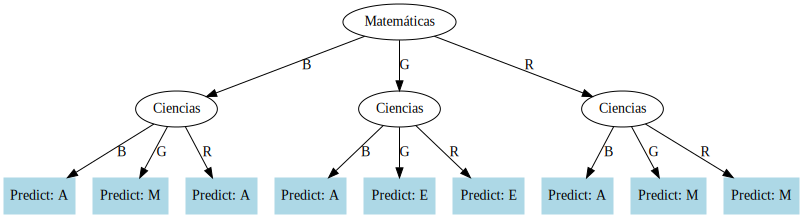


Predicciones para nuevos datos:
Instancia 1: Predicción = E
Instancia 2: Predicción = A


In [1]:
!apt-get install -qq graphviz
!pip install graphviz

import numpy as np
from collections import Counter
from graphviz import Digraph
from IPython.display import display

# ======================
# Clase Nodo del Árbol
# ======================
class Node:
    def __init__(self, feature=None, value=None, branches=None):
        self.feature = feature    # Índice de la característica para dividir
        self.value = value        # Valor de predicción (si es nodo hoja)
        self.branches = branches or {}  # Diccionario de ramas {valor_categoría: nodo_hijo}

# ======================
# Árbol de Decisión Categórico
# ======================
class CategoricalDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.feature_names = None
        self.class_names = None
        self.class_map = None

    def fit(self, X, y, feature_names=None, class_names=None):
        """Entrena el árbol con datos categóricos"""
        # Primero obtener las clases únicas de y
        unique_classes = np.unique(y)

        # Si no se proporcionan class_names, usar las clases únicas encontradas
        self.class_names = class_names if class_names is not None else unique_classes

        # Crear el mapeo de clases
        self.class_map = {cls: i for i, cls in enumerate(self.class_names)}

        # Verificar que todas las clases en y estén en class_names
        for cls in unique_classes:
            if cls not in self.class_map:
                raise ValueError(f"Class '{cls}' found in y but not in class_names")

        # Codificar y
        y_encoded = np.array([self.class_map[cls] for cls in y])

        # Procesar nombres de características
        self.feature_names = feature_names or [f"Feature_{i}" for i in range(X.shape[1])]

        # Construir el árbol
        self.root = self._build_tree(X, y_encoded)

    def _build_tree(self, X, y, depth=0):
        """Función recursiva para construir el árbol"""
        n_samples = X.shape[0]

        # Criterios de parada
        if len(np.unique(y)) == 1:
            return Node(value=y[0])

        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value=self._most_common_label(y))

        if n_samples < self.min_samples_split:
            return Node(value=self._most_common_label(y))

        # Encontrar la mejor división
        best_feature = self._find_best_split(X, y)
        if best_feature is None:
            return Node(value=self._most_common_label(y))

        # Dividir en subconjuntos
        branches = {}
        for category in np.unique(X[:, best_feature]):
            mask = X[:, best_feature] == category
            X_subset = X[mask]
            y_subset = y[mask]

            if len(X_subset) == 0:
                branches[category] = Node(value=self._most_common_label(y))
            else:
                branches[category] = self._build_tree(X_subset, y_subset, depth + 1)

        return Node(feature=best_feature, branches=branches)

    def _find_best_split(self, X, y):
        """Encuentra la mejor característica para dividir usando ganancia de información"""
        best_gain = -1
        best_feature = None

        for feature in range(X.shape[1]):
            gain = self._information_gain(X[:, feature], y)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        return best_feature if best_gain > 0 else None

    def _information_gain(self, feature_column, y):
        """Calcula la ganancia de información para una característica"""
        parent_entropy = self._entropy(y)

        values, counts = np.unique(feature_column, return_counts=True)
        weighted_entropy = 0

        for val, count in zip(values, counts):
            subset_y = y[feature_column == val]
            weighted_entropy += (count / len(y)) * self._entropy(subset_y)

        return parent_entropy - weighted_entropy

    def _entropy(self, y):
        """Calcula la entropía de un conjunto de etiquetas"""
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _most_common_label(self, y):
        """Devuelve la etiqueta más común"""
        if len(y) == 0:
            return 0
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        """Predice las clases para nuevos datos"""
        predictions = []
        for x in X:
            pred = self._predict_single(x, self.root)
            predictions.append(self.class_names[pred])
        return np.array(predictions)

    def _predict_single(self, x, node):
        """Predice una sola instancia"""
        if node.value is not None:
            return node.value

        feature_value = x[node.feature]
        if feature_value in node.branches:
            return self._predict_single(x, node.branches[feature_value])
        else:
            return self._most_common_label([])  # Valor por defecto si la categoría no se vio en entrenamiento

    def visualize(self):
        """Visualiza el árbol usando Graphviz"""
        dot = Digraph()

        def add_nodes(node, node_id):
            if node.value is not None:
                label = f"Predict: {self.class_names[node.value]}"
                dot.node(node_id, label, shape='box', style='filled', color='lightblue')
            else:
                label = self.feature_names[node.feature]
                dot.node(node_id, label, shape='ellipse')

            for category, child in node.branches.items():
                child_id = f"{node_id}_{category}"
                add_nodes(child, child_id)
                dot.edge(node_id, child_id, label=str(category))

        add_nodes(self.root, "root")
        display(dot)

# ======================
# Datos
# ======================

# Datos
data = np.array([
    ["G", "G", "R", "E"],
    ["R", "G", "B", "M"],
    ["B", "R", "G", "A"],
    ["G", "R", "G", "E"],
    ["R", "B", "R", "A"],
    ["G", "G", "G", "E"],
    ["B", "G", "R", "M"],
    ["R", "R", "R", "M"],
    ["G", "B", "G", "A"],
    ["B", "B", "B", "A"]
])

# Se separan características (X) y etiquetas (y)
X = data[:, :-1]
y = data[:, -1]

# Nombres de las características y clases
feature_names = ["Matemáticas", "Ciencias", "Inglés"]
class_names = ["A", "E", "M"]  # Asegúrate de incluir todas las clases presentes en y

# Se crea y entrena el árbol
tree = CategoricalDecisionTree(max_depth=3)
tree.fit(X, y, feature_names=feature_names, class_names=class_names)

# Se visualiza el árbol
print("Árbol de Decisión Categórico:")
tree.visualize()

# Se Predicen los nuevos datos
new_data = np.array([
    ["G", "G", "R"],
    ["B", "B", "G"]
])

predictions = tree.predict(new_data)
print("\nPredicciones para nuevos datos:")
for i, pred in enumerate(predictions):
    print(f"Instancia {i+1}: Predicción = {pred}")